In [101]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform


%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [102]:
study_area= gpd.read_file('68500_sub/68500_basin.shp')
interior_area= gpd.read_file('68500_sub/68500_river_buffer_cliped.shp')
topography_file = 'DEM_filled.tif'
base_resolution = 1000000 #1km
interior_resolution= 100 #10 m2


In [103]:
lons= np.array(study_area.exterior[0].coords)[:,0]; lats=np.array(study_area.exterior[0].coords)[:,1]
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
utm_coords_ext= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]
# lons= np.concatenate([np.array(interior_area.exterior[i].coords)[:,0] for i in range(len(interior_area))])
# lats=np.concatenate([np.array(interior_area.exterior[1].coords)[:,1] for i in range(len(interior_area))])
lons= np.array(interior_area.exterior[4].coords)[:,0]; lats=np.array(interior_area.exterior[4].coords)[:,1]
utm_coords_int= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]

Figure files for each frame will be stored in _plot


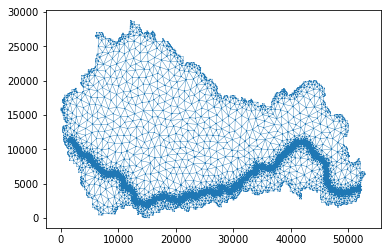

In [104]:
domain = anuga.create_domain_from_regions(
            utm_coords_ext,
            boundary_tags={'bottom': [0]},
            maximum_triangle_area=1000000,
            interior_regions=[[utm_coords_int, interior_resolution]],
#             fail_if_polygons_outside=False
            )

domain.set_name('68500') # Name of sww file
dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

In [105]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 191207


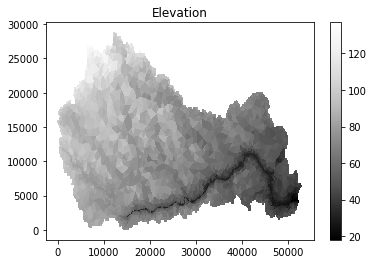

In [106]:
start= '20170826050000'
end= '20170829000000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation+10', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.01, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/ef5_param/crest_params/ksat_usa.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/ef5_param/crest_params/wm_usa.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/ef5_param/crest_params/b_usa.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/ef5_param/crest_params/im_usa.tif', location='centroids')
domain.set_quantity('KE', 0.5, location='centroids')

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='1H')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('1H')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [107]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'exterior': Bt})

In [ ]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=3600, duration=total_seconds)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=30)
#     domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics()
#     domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

evolving elements: 191207
Time = 2017-08-26 05:00:00, steps=0 (111s)
integral =  9110199396.373638
